# Covid-19 en La Paz

Exploración de casos de covid-19 en la ciudad de La Paz.

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, dates, cm, colors
import locale
import geopandas as gpd;
import datetime as dt
from IPython import display
import json
locale.setlocale(locale.LC_TIME, "es_US.UTF8");
plt.style.use('publish/estilo.mplstyle')

## Mortalidad por edad

Como es de esperarse, la mortalidad es superior entre personas mayores 60 años y ha estado decreciendo consistentemente a través de todos los grupos de edad. No es claro qué porciones de esta mejora se deben a más pruebas, vacunas o tratamientos.

In [94]:
def get_mortalidad(rango_size, freq):
    df = pd.read_csv('data/covid_lapaz/2021-12-04.csv', parse_dates=['registro', 'reporte'])
    df = df[(df.edad.notna()) & (df.registro.notna())]
    df['rango_edad'] = pd.cut(df.edad, bins=list(range(0,120, rango_size))).apply(lambda x: x.left)
    df = df[df.registro > '2020-03-01'].groupby([pd.Grouper(key='registro', freq=freq, label='right'), 'rango_edad']).caso.value_counts().reset_index(name='count').pivot_table(index=['registro', 'rango_edad'], columns='caso', values='count').reset_index().fillna(0)
    df['mortalidad'] = (df.fallecido / (df.fallecido + df.positivo + df.recuperado))
    df['registro'] = df.registro.apply(lambda x: x.replace(day=1))
    return df.pivot_table(index='registro', columns='rango_edad', values='mortalidad')

In [480]:
def plot_matrix(mortalidad, edad_min, edad_max, desde, hasta, rango_size):
    
    lincolor = '#88888f'
    dfi = mortalidad.loc[desde:hasta, edad_min:edad_max].replace(0,.001)
    
    f, ax = plt.subplots(1,1,figsize=(14,6))
    im = ax.imshow(dfi.T, cmap='magma', aspect='auto', norm=colors.LogNorm(vmin=.001, vmax=1.), alpha=.8, zorder=1)
    ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.columns)))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(['{} - {}'.format(i, i + rango_size) for i in dfi.columns]))
    ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.index)))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([i.strftime('%b') for i in dfi.index]))
    for axis, ticks in zip([ax.yaxis, ax.xaxis], [dfi.columns, dfi.index]):
        axis.set_minor_locator(ticker.FixedLocator([i + .485 for i in list(range(len(ticks)))]))
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.tick_params(which='major', axis='x')
    ax.grid(which='minor', color='#24242e', linestyle='-', linewidth=.5, alpha=1, zorder=2)
    ax.annotate('Rango de edad', xy=(-.1, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=90)
    ax.annotate('Mortalidad', xy=(1.045, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=270)
    
    cbar = f.colorbar(im, shrink=1., pad=.06, aspect=15)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0)
    labels = cbar.ax.get_yticks()
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator(labels))
    cbar.ax.set_yticklabels(['{:.0%}'.format(i) for i in labels])
    cbar.ax.tick_params(labelcolor=lincolor)

In [146]:
mortalidad = get_mortalidad(5, 'M')

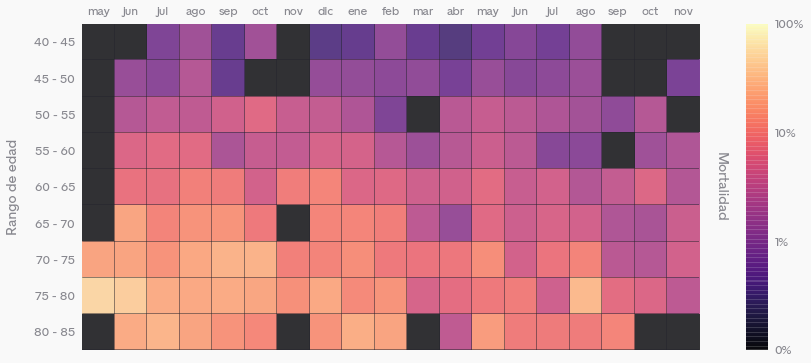

In [481]:
plot_matrix(mortalidad, 40, 80, '2020-05-01', '2021-11-01', 5)

## Dinámicas de contagio

Si la población joven está expuesta a más oportunidades de contagio, ¿existe un patrón en los datos que describa cómo contrae primero la enfermedad y luego contagia a gente mayor? Identifico 841 eventos donde al menos 5 personas contraen la enfermedad en un máximo de 90 días dentro del mismo manzano, con una media de 8.6 casos por evento y un máximo de 85 casos en un mismo evento. En promedio, la edad de los casos sube ligeramente desde el primer caso, pero existe demasiada dispersión para decir algo concluyente.

In [520]:
def get_manzanos():
    manzanos = gpd.read_file('data/poblacion_2020.json')
    manzanos = manzanos[manzanos._municipio == 'La Paz'][['id', 'geometry']]
    return manzanos

def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2021-12-04.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.edad.notna()) & (casos.registro.notna()) & (casos.lon.notna()) & (casos.lat.notna())]
    casos = gpd.GeoDataFrame(casos, geometry=gpd.points_from_xy(casos.lon, casos.lat), crs=manzanos.crs)
    return casos[['id', 'caso', 'sexo', 'edad', 'registro', 'geometry']]

def casos_en_manzanos():
    casos_manzanos = gpd.sjoin(manzanos, casos, op='contains')
    casos_manzanos.columns = ['manzano', 'geometry', 'i2', 'caso', 'resultado', 'sexo', 'edad', 'registro']
    casos_manzanos = casos_manzanos[['caso', 'manzano', 'registro', 'resultado', 'sexo', 'edad', 'geometry']]
    casos_manzanos = casos_manzanos.reset_index(drop=True)
    return casos_manzanos

def get_clusters(casos_manzanos, min_size, max_days):
    n = len(casos_manzanos.manzano.unique())
    for i, (m, manzano_df) in enumerate(casos_manzanos.groupby('manzano')):
        display.clear_output(wait=True)
        print('{}/{}'.format(i, n))
        if len(manzano_df) >= min_size:
            manzano_df = manzano_df.sort_values('registro')
            for ii, caso in manzano_df.iterrows():
                contagio = manzano_df[(manzano_df.registro >= caso.registro) & (manzano_df.registro <= (caso.registro + dt.timedelta(days=max_days)))]
                if len(contagio) >= min_size:
                    if clusters.__contains__(m):
                        if len(contagio) > len(clusters[m]):
                            clusters[m] = contagio['caso'].tolist()
                    else:
                        clusters[m] = contagio['caso'].tolist()

def edad_en_clusters(clusters, casos_manzanos):

    cluster_orden = []
    for cluster in clusters.keys():
        for i, caso in enumerate(clusters[cluster]):
            cluster_orden.append({'orden':i, 'caso':caso, 'cluster':cluster})

    clustero = pd.concat([pd.DataFrame(cluster_orden).set_index('caso'), casos_manzanos.set_index('caso').edad], axis=1).dropna()
    clustero[['orden', 'edad']] = clustero[['orden', 'edad']].astype(int)
    clustero = clustero.pivot_table(index='cluster', columns='orden', values='edad')
    return clustero

def plot_edad_por_orden(clustero):
    
    lincolor = '#88888f'

    spread = pd.concat([clustero.subtract(clustero[0], axis='index').mean().head(10), clustero.subtract(clustero[0], axis='index').std().head(10)], axis=1)
    spread.columns = ['mean', 'std']

    f, ax = plt.subplots(1,1,figsize=(12,8))
    ax.plot(spread['mean'], color='#e0674f', zorder=2, linewidth=3)
    ax.fill_between(spread.index, spread['mean'] - spread['std'], spread['mean'] + spread['std'], color='#e8eaed', zorder=1, alpha=.9, linewidth=0.5)
    ax.grid(axis='y')
    ax.grid(axis='x', alpha=1)
    ax.xaxis.set_major_locator(ticker.IndexLocator(1,0))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(7, prune='both'))
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.set_ylim(-30,30)
    ax.set_xlim(0,9.01)
    ax.axhline(0, color='#24242e', linewidth=.5)
    ax.annotate('Edad respecto al primer caso', xy=(-.07, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=90)
    ax.annotate('Orden de casos', xy=(.5, 1.07), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=lincolor)

In [ ]:
manzanos = get_manzanos()
casos = get_casos()
casos_manzanos = casos_en_manzanos()

clusters = {}
get_clusters(casos_manzanos, 5, 90)
eventos = edad_en_clusters(clusters, casos_manzanos)

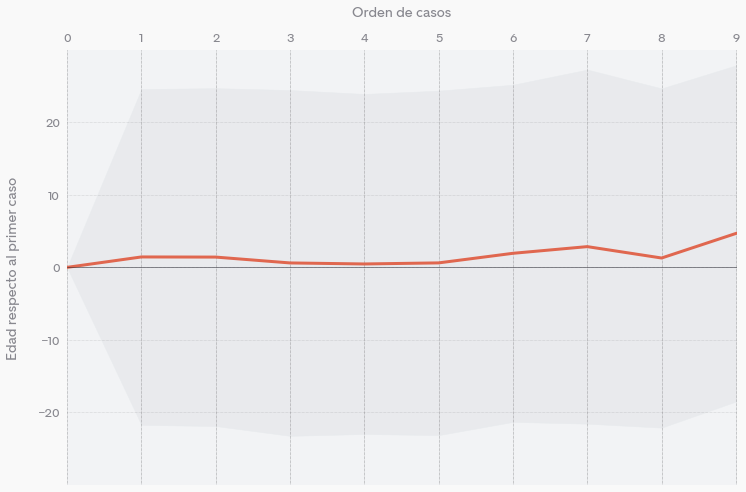

In [521]:
plot_edad_por_orden(eventos)